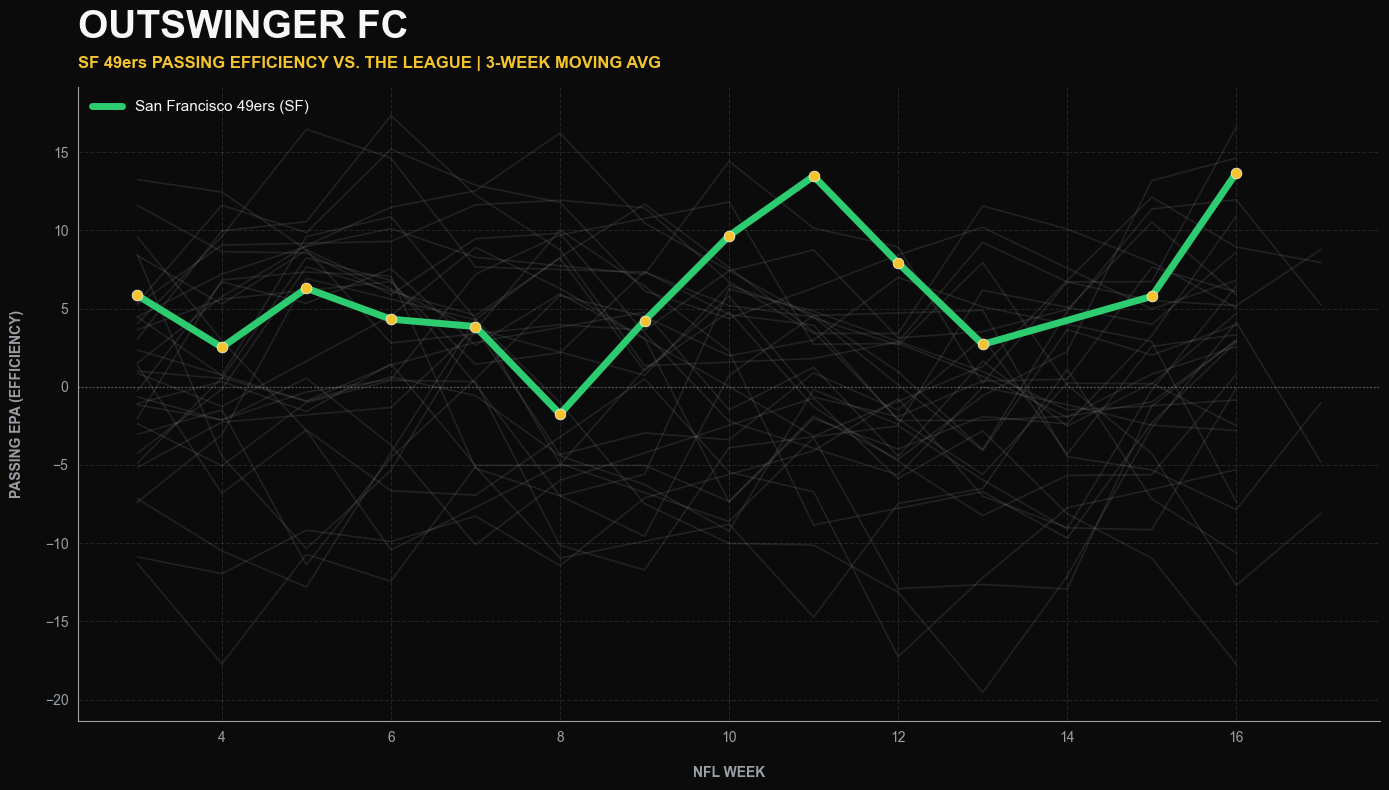

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION & COLORS ---
# Custom Outswinger FC branding palette
COLORS = {
    'yellow': '#F4C430',
    'black': '#0B0B0B',
    'white': '#F7F7F7',
    'grey': '#9AA0A6',
    'emerald': '#2ECC71'
}

# --- 2. DATA LOADING & PREPARATION ---
# Load the team stats dataset
df = pd.read_excel('/Users/user/nfl_team_stats_2025.xlsx')

# Ensure data is sorted chronologically for the moving average calculation
df = df.sort_values(['team', 'week'])

# Calculate 3-week Moving Average for all teams
# This smooths out the variance to reveal the true performance trend
df['passing_epa_ma'] = df.groupby('team')['passing_epa'].transform(lambda x: x.rolling(window=3).mean())

# --- 3. VISUALIZATION ---
plt.rcParams['font.family'] = 'sans-serif'
fig, ax = plt.subplots(figsize=(14, 8), facecolor=COLORS['black'])
ax.set_facecolor(COLORS['black'])

# Plot every other team in grey (The "League Context")
teams = df['team'].unique()
for team in teams:
    if team != 'SF':
        team_data = df[df['team'] == team]
        ax.plot(team_data['week'], team_data['passing_epa_ma'], 
                color=COLORS['grey'], alpha=0.15, linewidth=1.2, zorder=1)

# Highlight Buffalo (BUF) in Emerald (The "Outswinger" focus)
buf_data = df[df['team'] == 'SF']
ax.plot(buf_data['week'], buf_data['passing_epa_ma'], 
        color=COLORS['emerald'], linewidth=5, label='San Francisco 49ers (SF)', zorder=3)

# Add yellow highlights for specific data points on the Buffalo line
ax.scatter(buf_data['week'], buf_data['passing_epa_ma'], 
           color=COLORS['yellow'], s=60, edgecolors=COLORS['white'], linewidth=0.5, zorder=4)

# --- 4. BRANDING & STYLING ---
# Main Outswinger FC Header
ax.set_title('OUTSWINGER FC', fontsize=28, fontweight='black', 
             color=COLORS['white'], loc='left', pad=35)

# Report Subtitle
ax.text(0, 1.03, 'SF 49ers PASSING EFFICIENCY VS. THE LEAGUE | 3-WEEK MOVING AVG', 
        transform=ax.transAxes, color=COLORS['yellow'], fontsize=12, fontweight='bold')

# Axis Labels and Formatting
ax.set_xlabel('NFL WEEK', color=COLORS['grey'], fontsize=10, fontweight='bold', labelpad=15)
ax.set_ylabel('PASSING EPA (EFFICIENCY)', color=COLORS['grey'], fontsize=10, fontweight='bold', labelpad=15)

ax.tick_params(colors=COLORS['grey'], labelsize=10)
ax.grid(color=COLORS['white'], linestyle='--', alpha=0.1, zorder=0)

# Add League Average Baseline (0.0 EPA)
ax.axhline(0, color=COLORS['white'], linewidth=1, alpha=0.3, linestyle=':')

# Remove chart borders for a modern look
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_color(COLORS['grey'])
ax.spines['left'].set_color(COLORS['grey'])

# Legend configuration
ax.legend(loc='upper left', frameon=False, labelcolor=COLORS['white'], fontsize=11)

plt.tight_layout()
plt.savefig('/Users/user/NFL/outswinger_fc_full_report.png', dpi=300)
plt.show()

In [8]:
import pandas as pd
import json
import os
from datetime import timedelta
from pathlib import Path

# --- CONFIGURATION ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/') 
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')
DELTA_T = 5.0 # Seconds to wait for second ball retention

def calculate_sbrp_e(file_path):
    """Processes an individual JSON file."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except Exception:
        return pd.DataFrame()
    
    events_list = data.get('event', [])
    if not events_list: return pd.DataFrame()
        
    events = pd.DataFrame(events_list)
    events['timeStamp'] = pd.to_datetime(events['timeStamp'], format='ISO8601')
    
    # Controlled actions: Pass, Take On, Foul Won, Tackle, Recovery, Shots
    controlled_ids = [1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 49]
    
    # Filter for Long Balls
    long_balls = events[
        (events['typeId'] == 1) & 
        (events['qualifier'].apply(lambda x: any(q.get('qualifierId') == 1 for q in x) if isinstance(x, list) else False))
    ].copy()

    results = []
    for _, lb in long_balls.iterrows():
        start = lb['timeStamp']
        end = start + timedelta(seconds=DELTA_T)
        
        # Check window for next controlled action
        window = events[(events['timeStamp'] > start) & (events['timeStamp'] <= end)].sort_values('timeStamp')
        
        label = 0
        for _, row in window.iterrows():
            if row['typeId'] in controlled_ids:
                label = 1 if row['contestantId'] == lb['contestantId'] else 0
                break
                
        # Chaos: How many events happened in the zone immediately after?
        chaos = len(events[(events['timeStamp'] >= start) & (events['timeStamp'] <= start + timedelta(seconds=2))])
        
        results.append({'team_id': lb['contestantId'], 'outcome': label, 'chaos': chaos})
        
    return pd.DataFrame(results)

def run_combined_analysis():
    # 1. Build Team Map
    team_map = {}
    if MAPPING_FILE.exists():
        map_df = pd.read_csv(MAPPING_FILE)
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))

    # 2. Iterate Files
    all_dfs = []
    for json_file in FOLDER_PATH.glob('*.json'):
        all_dfs.append(calculate_sbrp_e(json_file))
            
    if not all_dfs:
        print("No data found.")
        return
        
    # 3. Aggregate
    df = pd.concat(all_dfs)
    df['team_name'] = df['team_id'].map(team_map).fillna(df['team_id'])
    
    analysis = df.groupby('team_name').agg(
        long_balls=('outcome', 'count'),
        retained=('outcome', 'sum'),
        avg_chaos=('chaos', 'mean')
    )
    analysis['SBRP-E_Score'] = (analysis['retained'] / analysis['long_balls']) * 100
    
    # Sort by the most efficient second-ball teams
    print(analysis.sort_values('SBRP-E_Score', ascending=False))
    analysis.to_csv('/Users/user/combined_sbrp_results.csv')

if __name__ == "__main__":
    run_combined_analysis()

            long_balls  retained  avg_chaos  SBRP-E_Score
team_name                                                
Utrecht           1138       444   1.369069     39.015817
PSV                944       364   1.306144     38.559322
Sparta            1142       423   1.293345     37.040280
Ajax               889       314   1.316085     35.320585
Twente            1211       425   1.365813     35.094963
NAC               1049       353   1.363203     33.651096
Telstar           1187       393   1.372367     33.108677
Groningen         1230       405   1.342276     32.926829
Excelsior         1227       404   1.358598     32.925835
Heracles          1114       362   1.350987     32.495512
Feyenoord          823       263   1.339004     31.956258
AZ                 915       292   1.295082     31.912568
Go Ahead          1222       377   1.273322     30.851064
NEC               1162       328   1.290017     28.227194
Heerenveen        1089       306   1.317723     28.099174
Volendam      

In [19]:
import pandas as pd
import json
import os
import numpy as np
from datetime import timedelta
from pathlib import Path
from sklearn.linear_model import LogisticRegression

# ==========================================
# CONFIGURATION
# ==========================================
# Update these paths to match your local folders
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/') 
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')

DELTA_T = 5.0  # Time window for second ball retention (seconds)
CHAOS_WINDOW = 2.0  # Time window for chaos score (seconds)
DENSITY_WINDOW = 3.0  # Lookback window for local density (seconds)

# ==========================================
# HELPER FUNCTIONS
# ==========================================

def calculate_pass_length(row):
    """Calculates pass distance in meters (approx based on 105x68 pitch)."""
    try:
        dx = (row['endX'] - row['x']) * 1.05
        dy = (row['endY'] - row['y']) * 0.68
        return np.sqrt(dx**2 + dy**2)
    except:
        return 0

def get_event_density(events, timestamp, team_id):
    """Calculates net action density in the 3 seconds prior to a pass."""
    start = timestamp - timedelta(seconds=DENSITY_WINDOW)
    pre_window = events[(events['timeStamp'] >= start) & (events['timeStamp'] < timestamp)]
    
    team_actions = len(pre_window[pre_window['contestantId'] == team_id])
    opp_actions = len(pre_window[pre_window['contestantId'] != team_id])
    
    return team_actions - opp_actions

def process_match_file(file_path):
    """Extracts long ball events and their features/outcomes from a single file."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Skipping {file_path.name}: {e}")
        return pd.DataFrame()
    
    events_list = data.get('event', [])
    if not events_list: return pd.DataFrame()
        
    events = pd.DataFrame(events_list)
    events['timeStamp'] = pd.to_datetime(events['timeStamp'], format='ISO8601')
    
    # Controlled actions (possession-defining events)
    # 1=Pass, 3=Take On, 4=Foul Won, 7=Tackle, 8=Interception, 10=Save, 13-16=Shots, 49=Recovery
    controlled_ids = [1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 49]
    
    # Filter for Long Balls (Qualifier 1)
    long_balls = events[
        (events['typeId'] == 1) & 
        (events['qualifier'].apply(lambda x: any(q.get('qualifierId') == 1 for q in x) if isinstance(x, list) else False))
    ].copy()

    rows = []
    for _, lb in long_balls.iterrows():
        start_time = lb['timeStamp']
        end_time = start_time + timedelta(seconds=DELTA_T)
        
        # 1. ACTUAL OUTCOME (SBRP-E Label)
        window = events[(events['timeStamp'] > start_time) & (events['timeStamp'] <= end_time)].sort_values('timeStamp')
        outcome = 0
        for _, row in window.iterrows():
            if row['typeId'] in controlled_ids:
                outcome = 1 if row['contestantId'] == lb['contestantId'] else 0
                break
                
        # 2. FEATURE: CHAOS SCORE
        chaos = len(events[(events['timeStamp'] >= start_time) & (events['timeStamp'] <= start_time + timedelta(seconds=CHAOS_WINDOW))])
        
        # 3. FEATURE: LOCAL DENSITY
        density = get_event_density(events, start_time, lb['contestantId'])
        
        # 4. FEATURE: LANDING GEOMETRY
        # Opta uses x/y for origin. We use endX/endY for landing context.
        lx = lb.get('endX', lb['x'])
        ly = lb.get('endY', lb['y'])
        
        # 5. FEATURE: PASS LENGTH
        length = calculate_pass_length(lb)
        
        rows.append({
            'team_id': lb['contestantId'],
            'outcome': outcome,
            'chaos': chaos,
            'density': density,
            'land_x': lx,
            'land_y': ly,
            'length': length
        })
        
    return pd.DataFrame(rows)

# ==========================================
# MAIN EXECUTION
# ==========================================

def run_xsbr_model():
    # A. Build Team Mapping
    team_map = {}
    if MAPPING_FILE.exists():
        map_df = pd.read_csv(MAPPING_FILE)
        # Search for contestant ID/Name pairs in standard Opta CSV columns
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))

    # B. Aggregate all data for training
    print(f"Scanning folder: {FOLDER_PATH}...")
    all_data_list = []
    for json_file in FOLDER_PATH.glob('*.json'):
        df_match = process_match_file(json_file)
        if not df_match.empty:
            all_data_list.append(df_match)
            
    if not all_data_list:
        print("Error: No data found. Check your folder path and JSON structure.")
        return
        
    master_df = pd.concat(all_data_list).dropna()
    print(f"Total long balls extracted: {len(master_df)}")

    # C. Train the Expected Model (Logistic Regression)
    # Features that define the difficulty of retaining the second ball
    feature_cols = ['chaos', 'density', 'land_x', 'land_y', 'length']
    X = master_df[feature_cols]
    y = master_df['outcome']
    
    if len(master_df) < 20:
        print("Warning: Sample size is very small. xSBR results may be volatile.")
    
    clf = LogisticRegression()
    clf.fit(X, y)
    
    # Generate the Expected Probability (xSBR)
    master_df['xSBR'] = clf.predict_proba(X)[:, 1]
    
    # Calculate Value Added (Actual - Expected)
    master_df['SBR_Added'] = master_df['outcome'] - master_df['xSBR']
    
    # D. Aggregate by Team
    master_df['team_name'] = master_df['team_id'].map(team_map).fillna(master_df['team_id'])
    
    summary = master_df.groupby('team_name').agg(
        long_balls=('outcome', 'count'),
        actual_retained=('outcome', 'sum'),
        expected_retained=('xSBR', 'sum'),
        total_value_added=('SBR_Added', 'sum'),
        avg_chaos=('chaos', 'mean')
    ).reset_index()
    
    # Final Metrics
    summary['SBR_Success_Rate'] = (summary['actual_retained'] / summary['long_balls']) * 100
    summary['Performance_Index'] = summary['actual_retained'] / summary['expected_retained']
    
    # Sort and Display
    summary = summary.sort_values('total_value_added', ascending=False)
    
    print("\n--- EXPECTED SECOND BALL RETENTION (xSBR) SUMMARY ---")
    print(summary[['team_name', 'long_balls', 'SBR_Success_Rate', 'total_value_added', 'Performance_Index']])
    
    # Save results
    summary.to_excel('/Users/user/Models/xSBR/xsbr_full_analysis.xlsx', index=False)
    print("\nFull analysis saved to 'xsbr_full_analysis.xlsx'")

if __name__ == "__main__":
    run_xsbr_model()

Scanning folder: /Users/user/XG/Eredivisie 2025-2026/DONE...
Total long balls extracted: 19557

--- EXPECTED SECOND BALL RETENTION (xSBR) SUMMARY ---
     team_name  long_balls  SBR_Success_Rate  total_value_added  \
15     Utrecht        1138         39.015817          73.430539   
12      Sparta        1142         37.040280          63.051877   
11         PSV         944         38.559322          58.508842   
1         Ajax         889         35.320585          31.049287   
14      Twente        1211         35.094963          26.896732   
2    Excelsior        1227         32.925835          14.667388   
9          NAC        1049         33.651096          11.132478   
13     Telstar        1187         33.108677           7.937488   
8     Heracles        1114         32.495512           4.863628   
6    Groningen        1230         32.926829           0.015499   
0           AZ         915         31.912568          -0.788969   
3    Feyenoord         823         31.956258  

Analyzing 143 matches...


100%|██████████| 143/143 [00:49<00:00,  2.87it/s]



--- FINAL SBRP-E RANKINGS ---
     team_name  long_balls  avg_chaos  SBRP_E_Score
11         PSV         754   0.383289     48.275862
15     Utrecht         940   0.446809     47.234043
12      Sparta         940   0.356383     45.000000
1         Ajax         720   0.391667     43.611111
14      Twente        1001   0.442557     42.457542
0           AZ         701   0.383738     41.654779
9          NAC         848   0.449292     41.627358
2    Excelsior         978   0.449898     41.308793
13     Telstar         982   0.450102     40.020367
6    Groningen        1019   0.427870     39.744848
8     Heracles         912   0.427632     39.692982
3    Feyenoord         682   0.420821     38.563050
5     Go Ahead         997   0.335005     37.813440
16    Volendam         762   0.395013     37.270341
10         NEC         908   0.371145     36.123348
7   Heerenveen         853   0.413834     35.873388
17      Zwolle         823   0.392467     32.685298
4      Fortuna         897   0.38

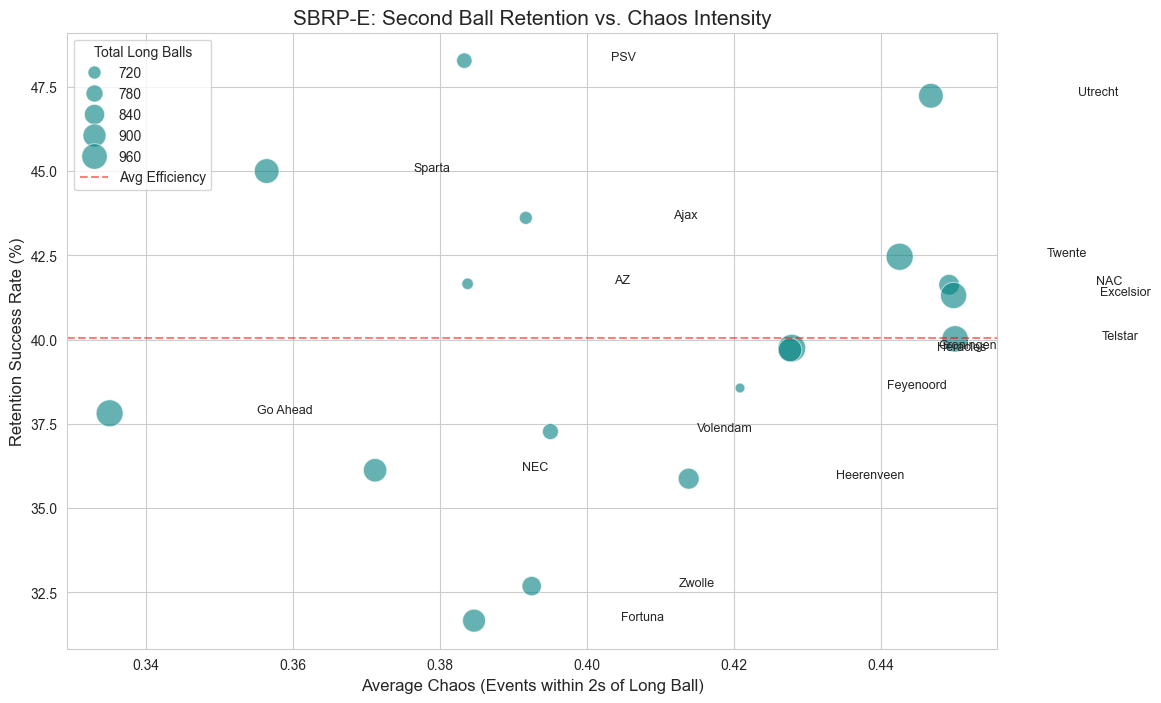

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from pathlib import Path
from tqdm import tqdm

# --- CONFIGURATION ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/') 
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')
OUTPUT_PATH = Path('/Users/user/combined_sbrp_results.csv')

DELTA_T = 5.0  # Window for retention
CHAOS_T = 2.0  # Window for "Chaos" intensity
CONTROLLED_IDS = {1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 49}

def calculate_sbrp_e(file_path):
    """Processes an individual JSON file with optimized window searching."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except Exception:
        return pd.DataFrame()
    
    events_list = data.get('event', [])
    if not events_list: return pd.DataFrame()
        
    df = pd.DataFrame(events_list)
    df['timeStamp'] = pd.to_datetime(df['timeStamp'], format='ISO8601')
    
    # Identify Long Balls (typeId 1 + qualifierId 1)
    # We use a helper to check qualifiers efficiently
    is_long_ball = (df['typeId'] == 1) & df['qualifier'].apply(
        lambda x: any(q.get('qualifierId') == 1 for q in x) if isinstance(x, list) else False
    )
    
    long_balls = df[is_long_ball].copy()
    results = []

    for idx, lb in long_balls.iterrows():
        start_time = lb['timeStamp']
        end_time = start_time + timedelta(seconds=DELTA_T)
        chaos_limit = start_time + timedelta(seconds=CHAOS_T)
        
        # Look ahead at the next few events (slices are faster than global filters)
        window = df.iloc[idx + 1 : idx + 15]
        window = window[window['timeStamp'] <= end_time]
        
        if window.empty:
            continue

        # 1. Determine Outcome (Retention)
        # Find first event in window that matches controlled_ids
        retention_event = window[window['typeId'].isin(CONTROLLED_IDS)].head(1)
        
        outcome = 0
        if not retention_event.empty:
            outcome = 1 if retention_event.iloc[0]['contestantId'] == lb['contestantId'] else 0
                
        # 2. Chaos Metric (Density of events in the immediate 2s scramble)
        chaos_count = len(window[window['timeStamp'] <= chaos_limit])
        
        results.append({
            'team_id': lb['contestantId'], 
            'outcome': outcome, 
            'chaos': chaos_count,
            'x': lb.get('x', 0),
            'y': lb.get('y', 0)
        })
        
    return pd.DataFrame(results)

def run_combined_analysis():
    # 1. Build Team Map
    team_map = {}
    if MAPPING_FILE.exists():
        map_df = pd.read_csv(MAPPING_FILE)
        # Handle Opta's nested JSON-to-CSV structure
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))

    # 2. Iterate Files with Progress Bar
    all_dfs = []
    json_files = list(FOLDER_PATH.glob('*.json'))
    
    print(f"Analyzing {len(json_files)} matches...")
    for json_file in tqdm(json_files):
        all_dfs.append(calculate_sbrp_e(json_file))
            
    if not all_dfs:
        print("No data found.")
        return
        
    # 3. Aggregate Results
    full_df = pd.concat(all_dfs)
    full_df['team_name'] = full_df['team_id'].map(team_map).fillna(full_df['team_id'])
    
    analysis = full_df.groupby('team_name').agg(
        long_balls=('outcome', 'count'),
        retained=('outcome', 'sum'),
        avg_chaos=('chaos', 'mean')
    ).reset_index()
    
    analysis['SBRP_E_Score'] = (analysis['retained'] / analysis['long_balls']) * 100
    
    # 4. Filter out teams with low sample size (e.g., < 10 long balls)
    analysis = analysis[analysis['long_balls'] > 10].sort_values('SBRP_E_Score', ascending=False)
    
    print("\n--- FINAL SBRP-E RANKINGS ---")
    print(analysis[['team_name', 'long_balls', 'avg_chaos', 'SBRP_E_Score']])
    
    # 5. Export and Plot
    analysis.to_csv(OUTPUT_PATH, index=False)
    plot_results(analysis)

def plot_results(df):
    """Generates a scatter plot of Chaos vs Efficiency."""
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    plot = sns.scatterplot(
        data=df, x='avg_chaos', y='SBRP_E_Score', 
        size='long_balls', sizes=(50, 400), alpha=0.6, color='teal'
    )
    
    # Add labels to points
    for i in range(df.shape[0]):
        plt.text(df.avg_chaos[i]+0.02, df.SBRP_E_Score[i], df.team_name[i], fontsize=9)

    plt.title('SBRP-E: Second Ball Retention vs. Chaos Intensity', fontsize=15)
    plt.xlabel('Average Chaos (Events within 2s of Long Ball)', fontsize=12)
    plt.ylabel('Retention Success Rate (%)', fontsize=12)
    plt.axhline(df['SBRP_E_Score'].mean(), color='red', linestyle='--', alpha=0.5, label='Avg Efficiency')
    plt.legend(title='Total Long Balls')
    plt.show()

if __name__ == "__main__":
    run_combined_analysis()